# LP-IV *Group B: Machine Learning*
### Problem Statement:
##### Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
##### Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

##### Dataset link: 
```bash
https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

# 1. Import Required Libraries

In [4]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 2. Read dataset

In [5]:
df = pd.read_csv("uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [8]:
df.info()
df.describe()
df.isna().sum()

# display min/max lat/lon to ensure coordinates look sane
for col in ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']:
    if col in df.columns:
        print(col, df[col].min(), df[col].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
pickup_latitude -74.01551500000001 1644.421482
pickup_longitude -1340.64841 57.418457
dropoff_latitude -881.9855130000001 872.6976279999999
dropoff_longitude -3356.6663 1153.5726029999998


In [9]:
df.columns = [c.strip().lower() for c in df.columns]
# Example: parse a timestamp field if present
if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
# otherwise inspect column names and adapt

In [10]:
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month'] = df['pickup_datetime'].dt.month

In [12]:
# Example safe filters (adjust thresholds as needed)
df = df.dropna(subset=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','fare_amount'])
df['fare_amount'] = pd.to_numeric(df['fare_amount'], errors='coerce')
df = df[(df['fare_amount'] > 0.5) & (df['fare_amount'] < 500)]
# passenger count if available
if 'passenger_count' in df.columns:
    df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce')
    df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # returns kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

df['distance_km'] = haversine_distance(df['pickup_latitude'].values,
                                      df['pickup_longitude'].values,
                                      df['dropoff_latitude'].values,
                                      df['dropoff_longitude'].values)

# Optional transforms
df['log_distance'] = np.log1p(df['distance_km'])
df['fare_per_km'] = df['fare_amount'] / df['distance_km']

In [14]:
# IQR method example for fare
def iqr_bounds(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

low, high = iqr_bounds(df['fare_amount'])
print("Fare IQR bounds:", low, high)
outliers = df[(df['fare_amount'] < low) | (df['fare_amount'] > high)]
len(outliers)
# If you want to remove
df_clean = df[(df['fare_amount'] >= low) & (df['fare_amount'] <= high)]

Fare IQR bounds: -3.75 22.25


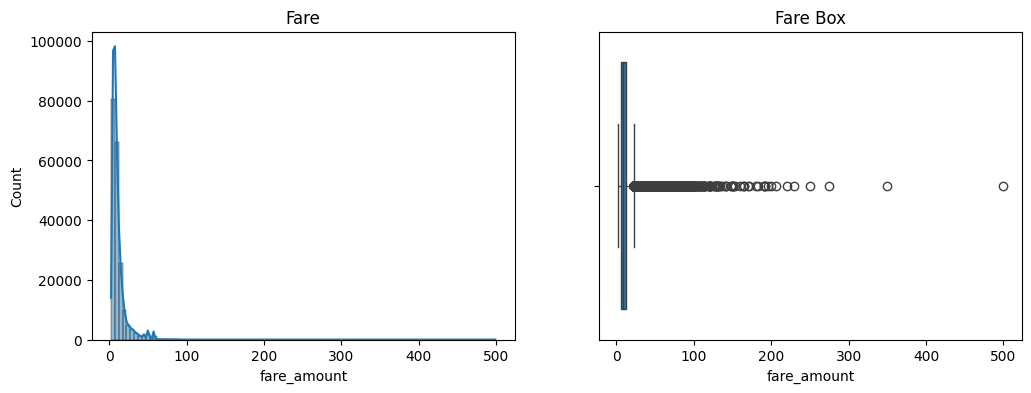

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); sns.histplot(df['fare_amount'], bins=100, kde=True); plt.title('Fare')
plt.subplot(1,2,2); sns.boxplot(x=df['fare_amount']); plt.title('Fare Box')
plt.show()

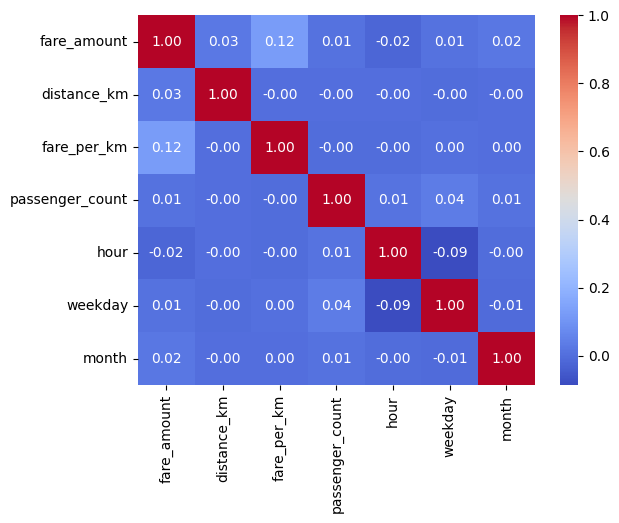

In [16]:
numeric = ['fare_amount','distance_km','fare_per_km']
if 'passenger_count' in df.columns: numeric.append('passenger_count')
if 'hour' in df.columns: numeric.extend(['hour','weekday','month'])
corr = df[numeric].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [17]:
features = ['distance_km']
if 'passenger_count' in df.columns: features.append('passenger_count')
if 'hour' in df.columns: features += ['hour','weekday']

X = df_clean[features]   # or df if you didn't remove outliers
y = df_clean['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [19]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)       # RF doesn't require scaling
y_pred_rf = rf.predict(X_test)


In [20]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)       # RF doesn't require scaling
y_pred_rf = rf.predict(X_test)


In [21]:
from math import sqrt
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}

print("Linear Regression:", evaluate(y_test, y_pred_lr))
print("Random Forest:", evaluate(y_test, y_pred_rf))


Linear Regression: {'r2': 0.0005982348652550096, 'rmse': 4.1520421266548375, 'mae': 3.3065325445637117}
Random Forest: {'r2': 0.6367578510195828, 'rmse': 2.5031669341328766, 'mae': 1.7883375756423592}


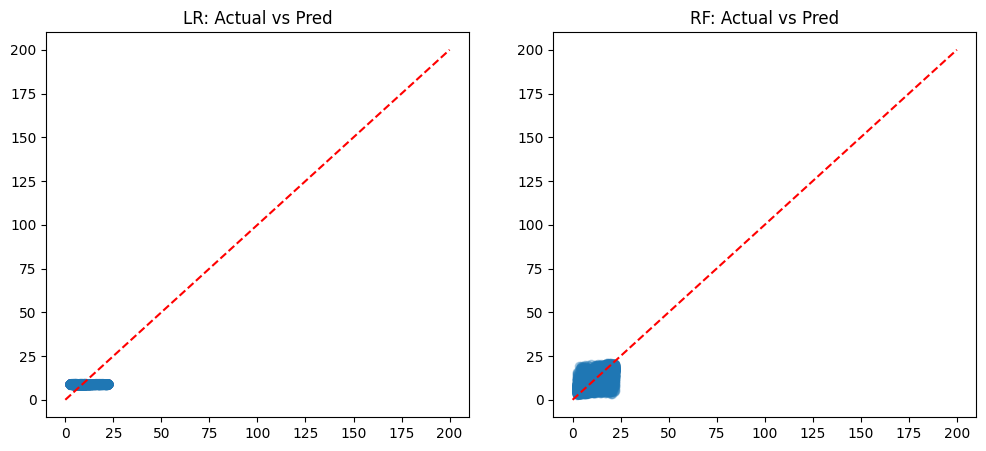

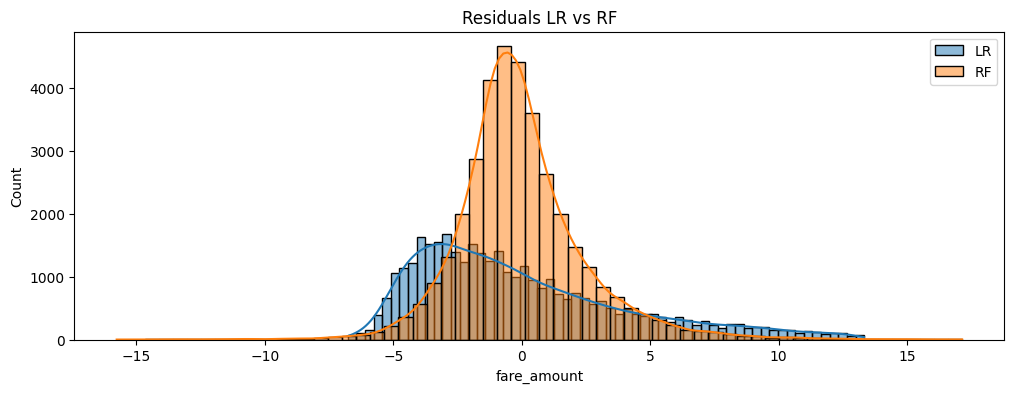

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.scatter(y_test, y_pred_lr, alpha=0.3); plt.title('LR: Actual vs Pred'); plt.plot([0,200],[0,200],'r--')
plt.subplot(1,2,2); plt.scatter(y_test, y_pred_rf, alpha=0.3); plt.title('RF: Actual vs Pred'); plt.plot([0,200],[0,200],'r--')
plt.show()

# Residual histograms
plt.figure(figsize=(12,4))
sns.histplot(y_test - y_pred_lr, kde=True, label='LR', bins=60); sns.histplot(y_test - y_pred_rf, kde=True, label='RF', bins=60);
plt.legend(); plt.title('Residuals LR vs RF'); plt.show()